## Testing diffusion Schrödinger Bridge

In [1]:
import toml
from pathlib import Path
from utils.config import *
import torch
from diffusion.dsb import IPF
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
caps_dir = Path("/lustre/fswork/projects/rech/krk/commun/datasets/IXI/caps_IXI")
expe_dir = Path("experiments/dsb35")
transfer = True

dsb = IPF(caps_dir, expe_dir, transfer)
dsb.device

'cuda'

In [3]:
dsb.train()

Training initial forward pass
IPF iteration: 1/2
Cache size: torch.Size([12000, 2, 1, 64, 64])
Load time: 1.3819046020507812


  0%|          | 1/201 [00:01<06:09,  1.85s/it]

Initial variance: 0.07703134564741276
Final variance: 1.7316030794405037


 50%|####9     | 100/201 [00:34<00:21,  4.72it/s]

Cache size: torch.Size([12000, 2, 1, 64, 64])
Load time: 0.2367861270904541


100%|#########9| 200/201 [00:56<00:00,  4.72it/s]

Cache size: torch.Size([12000, 2, 1, 64, 64])
Load time: 0.23219680786132812


100%|##########| 201/201 [00:57<00:00,  3.51it/s]


Cache size: torch.Size([12000, 2, 1, 64, 64])
Load time: 32.55448246002197


  0%|          | 1/201 [00:00<00:42,  4.68it/s]

Initial variance: 0.09051755712425802
Final variance: 1912685.6235366464


 50%|####9     | 100/201 [00:30<00:21,  4.72it/s]

Cache size: torch.Size([12000, 2, 1, 64, 64])
Load time: 23.6354820728302


100%|#########9| 200/201 [01:15<00:00,  4.72it/s]

Cache size: torch.Size([12000, 2, 1, 64, 64])
Load time: 23.655845880508423


100%|##########| 201/201 [01:39<00:00,  2.02it/s]


IPF iteration: 2/2
Cache size: torch.Size([12000, 2, 1, 64, 64])
Load time: 23.650023460388184


  0%|          | 1/201 [00:00<00:42,  4.68it/s]

Initial variance: 0.0810627482036077
Final variance: 1.3757807300898008


 50%|####9     | 100/201 [00:30<00:21,  4.72it/s]

Cache size: torch.Size([12000, 2, 1, 64, 64])
Load time: 23.690815448760986


100%|#########9| 200/201 [01:15<00:00,  4.74it/s]

Cache size: torch.Size([12000, 2, 1, 64, 64])
Load time: 23.694382190704346


100%|##########| 201/201 [01:39<00:00,  2.02it/s]


Cache size: torch.Size([12000, 2, 1, 64, 64])
Load time: 23.621706247329712


  0%|          | 1/201 [00:00<00:42,  4.69it/s]

Initial variance: 0.09418947255377308
Final variance: 77757.41100222245


 50%|####9     | 100/201 [00:30<00:21,  4.72it/s]

Cache size: torch.Size([12000, 2, 1, 64, 64])
Load time: 23.662025928497314


100%|#########9| 200/201 [01:15<00:00,  4.72it/s]

Cache size: torch.Size([12000, 2, 1, 64, 64])
Load time: 23.659121990203857


100%|##########| 201/201 [01:39<00:00,  2.02it/s]


## Path on validation set

In [18]:
import toml
from pathlib import Path
import math
from utils.config import *
import numpy as np

import torch
from diffusion.dsb import IPF

from torchvision import transforms
from image_datasets.capsSlicesIXI import CapsSlicesIXI
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

In [19]:
caps_dir = Path("/lustre/fswork/projects/rech/krk/commun/datasets/IXI/caps_IXI")
expe_dir = Path("experiments/dsb49")
transfer = True

dsb = IPF(caps_dir, expe_dir, transfer)
dsb.device

'cuda'

In [20]:
n_ipf = 7
fb = 'b'

dsb.ema_helpers["f"].load_state_dict(torch.load(expe_dir / "checkpoints" / f"sample_net_f_{n_ipf}_10000.ckpt"))
dsb.ema_helpers["b"].load_state_dict(torch.load(expe_dir / "checkpoints" / f"sample_net_b_{n_ipf}_10000.ckpt"))

In [21]:
transform=transforms.Compose([
        transforms.Pad([0, 18], fill=-1),
        transforms.Resize((64, 64)),
        #transforms.Lambda(lambda t: (t+1)/2),    # Image range between [0, 1]
    ])

val_tsv = caps_dir / "IXI_validation.tsv"
val_set = CapsSlicesIXI(caps_dir, val_tsv, sequence='T2', transformations=transform)
val_loader = DataLoader(
    val_set,
    batch_size=64,
    shuffle=False,
    num_workers=8,
    drop_last=True,
)

In [22]:
batch = next(iter(val_loader))['T2'][0].unsqueeze(dim=0)
print(batch.shape)

torch.Size([1, 1, 64, 64])


In [23]:
batch.device

device(type='cpu')

In [24]:
with torch.no_grad():
    x_tot, out, steps_expanded = dsb.langevin.record_langevin_seq(
                        dsb.ema_helpers[fb].ema_copy(dsb.net[fb]),
                        #dsb.net[fb],
                        batch.to('cuda'),
                        ipf_it=n_ipf,
                        sample=True
                    )

In [27]:
(expe_dir / "paths").mkdir(exist_ok=True)

# Number of images (frames) in the GIF
N = dsb.num_steps

# Create a figure and axis
fig, ax = plt.subplots()

# Load the first image to set up the plot
img = x_tot[0][0].squeeze().cpu()
im = ax.imshow(img, cmap='grey', vmin=-1, vmax=1)

#for i in range(dsb.num_steps):
#    im = plt.imshow(x_tot[0][i].squeeze().cpu(), cmap='grey', vmin=-1, vmax=1, animated=True)
#    imgs.append([im])

# Function to update the image for each frame
def update(i):
    # Load the ith image
    img = x_tot[0][i].squeeze().cpu()
    # Update the image data in the plot
    im.set_array(img)
    return [im]

ani = animation.FuncAnimation(fig, update, frames=N, blit=True)

# Save the animation as a GIF
ani.save(expe_dir / "paths" / f"ipf_{n_ipf}_{fb}_path.gif", writer='pillow', fps=5)

#ani = animation.ArtistAnimation(fig, imgs, interval=70, blit=True, repeat_delay=70*dsb.num_steps)
#ani.save(expe_dir / "paths" / f"ipf_{n_ipf}_{fb}_path.gif", writer='pillow')
plt.close()

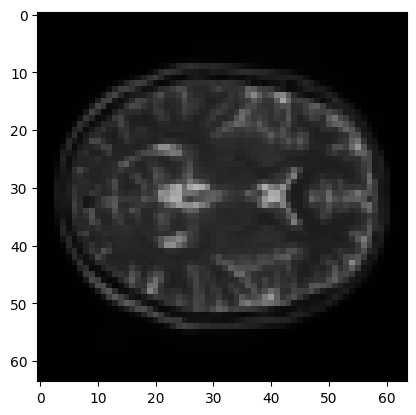

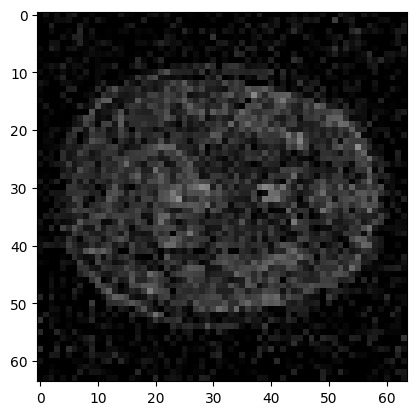

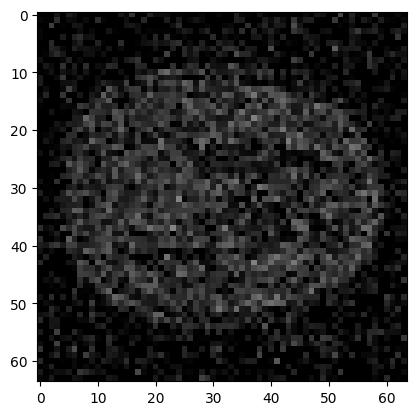

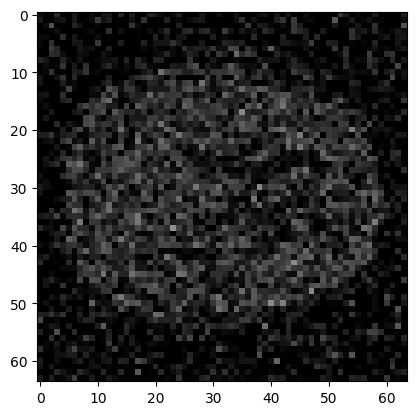

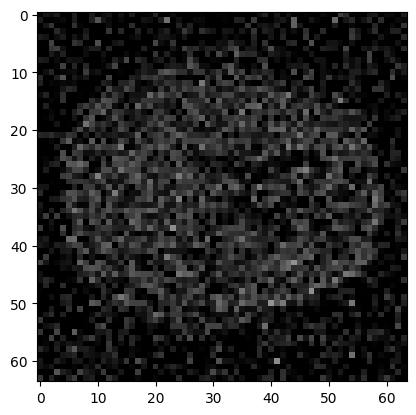

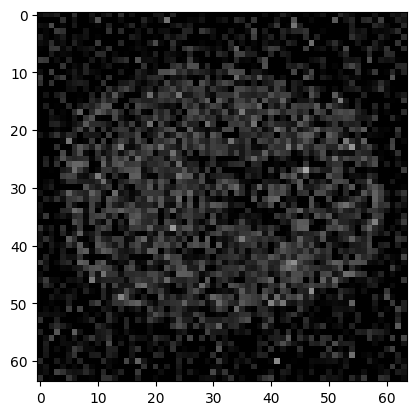

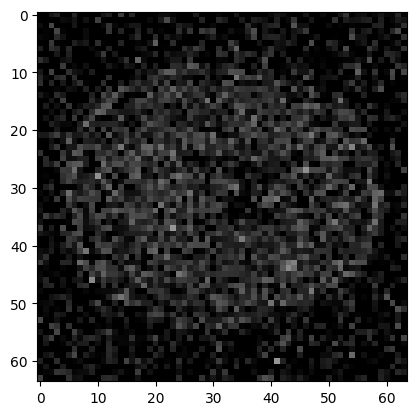

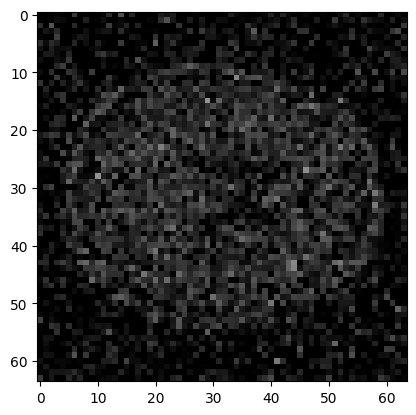

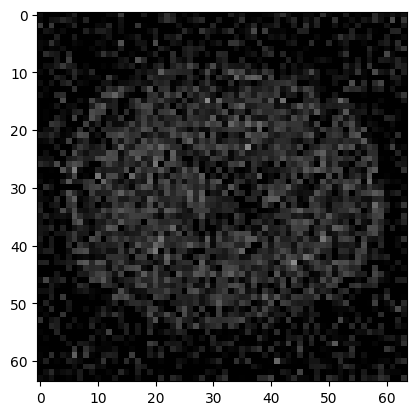

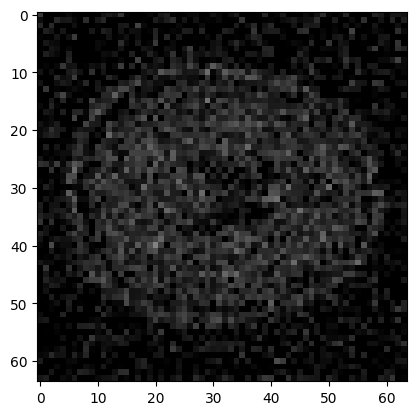

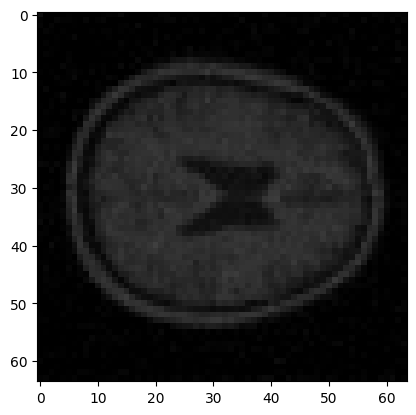

In [31]:
plt.imshow(batch.squeeze(), cmap='grey', vmin=-1, vmax=1)
plt.show()

for i in range(dsb.num_steps):
    plt.imshow(x_tot[0][i].squeeze().cpu(), cmap='grey', vmin=-1, vmax=1)
    plt.show()

In [1]:
import torch

# Create a CUDA tensor
tensor = torch.randn(1000, 1000).cuda()

# Check memory usage before deletion
print(f"Memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

# Delete the CUDA tensor
del tensor

# Clear unused memory
torch.cuda.empty_cache()

# Check memory usage after deletion
print(f"Memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

Memory allocated: 3.81 MB
Memory allocated: 0.00 MB


In [ ]:
dsb.x_tot_plot.shape

In [8]:
dsb.x_tot_plot[:, 0, 0,]

tensor([[[ 0.2362,  0.2925, -0.0465,  ...,  0.3279,  0.3912,  0.2453],
         [ 0.4684,  0.3272,  0.5919,  ...,  0.4012,  0.4272,  0.4843],
         [ 0.3540,  0.4158,  0.4001,  ...,  0.4967,  0.3747,  0.4446],
         ...,
         [ 0.5429,  0.4067,  0.3849,  ...,  0.5750,  0.5848,  0.5175],
         [ 0.5419,  0.6273,  0.5570,  ...,  0.4372,  0.5293,  0.5242],
         [ 0.5796,  0.5819,  0.5896,  ...,  0.6719,  0.2876,  0.6547]],

        [[ 0.4698,  0.3297,  0.2346,  ...,  0.4196,  0.4760,  0.4943],
         [ 0.8945,  0.1868,  0.4766,  ...,  0.3048,  0.5529,  0.5519],
         [ 0.6029,  0.5410,  0.1618,  ...,  0.2747,  0.1570,  0.5890],
         ...,
         [ 0.5149,  0.2590,  0.1509,  ...,  0.2938,  0.3081,  0.5274],
         [ 0.7411,  0.5484,  0.3909,  ...,  0.2960,  0.3526,  0.4897],
         [ 0.9353,  0.5847,  0.8319,  ...,  0.5795,  0.5860,  0.7528]],

        [[ 0.9031,  0.2657,  0.2308,  ...,  0.5911,  0.4313,  0.7270],
         [ 0.7022,  0.0675, -0.0679,  ...,  0

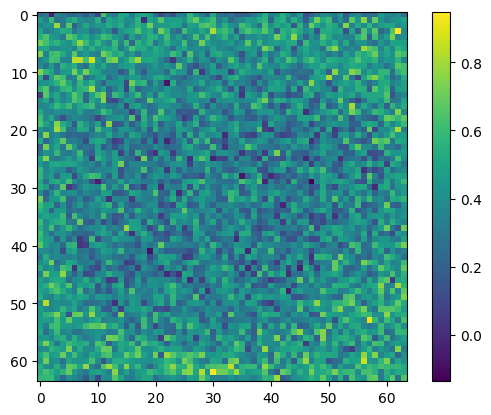

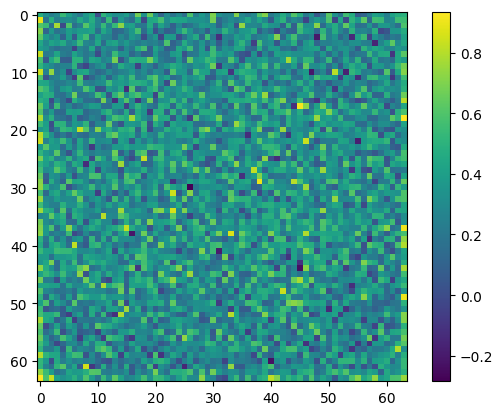

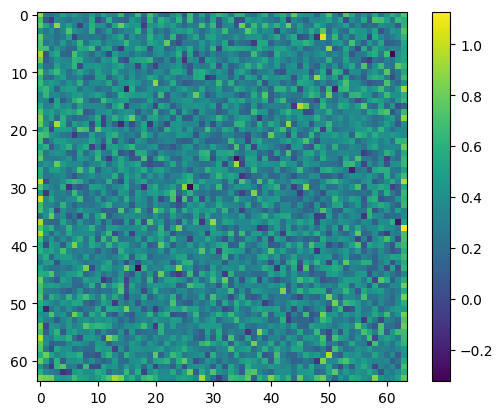

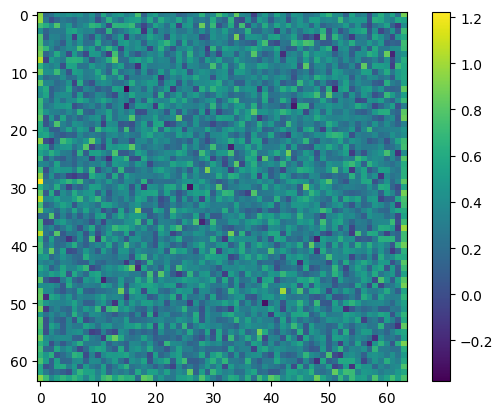

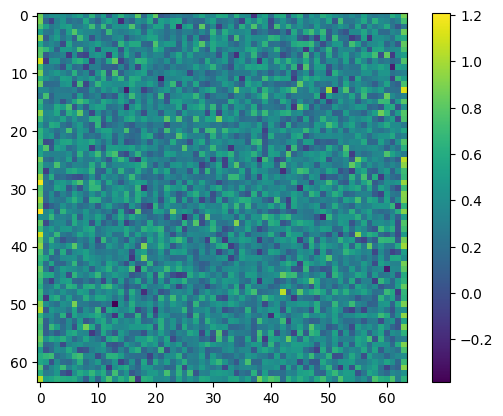

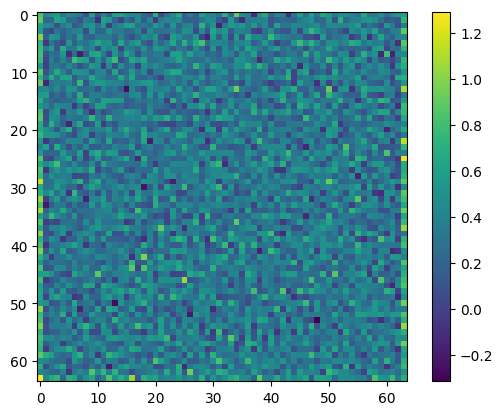

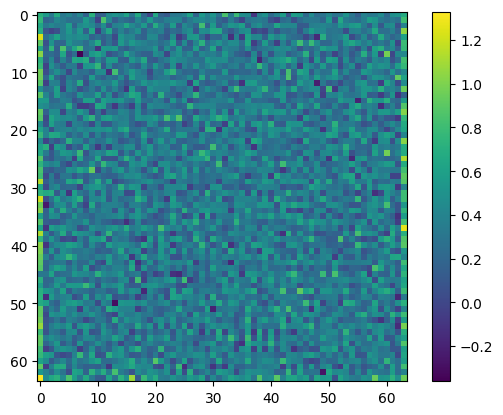

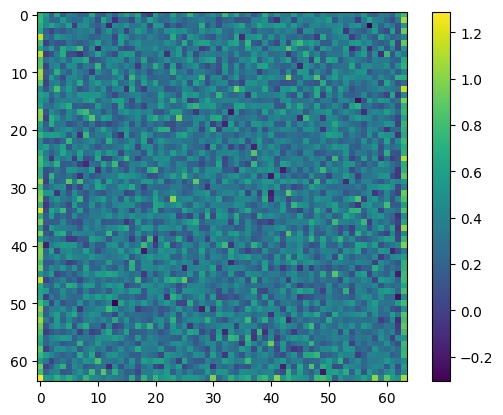

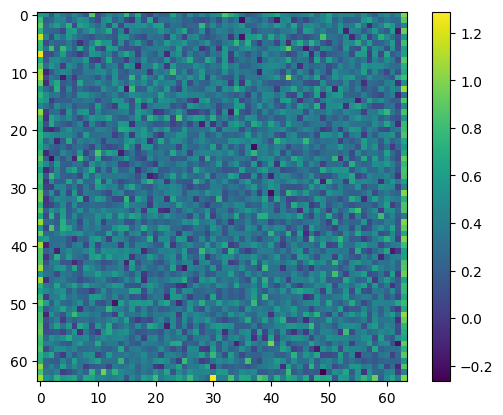

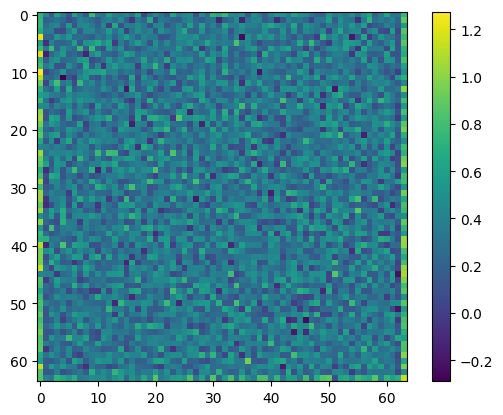

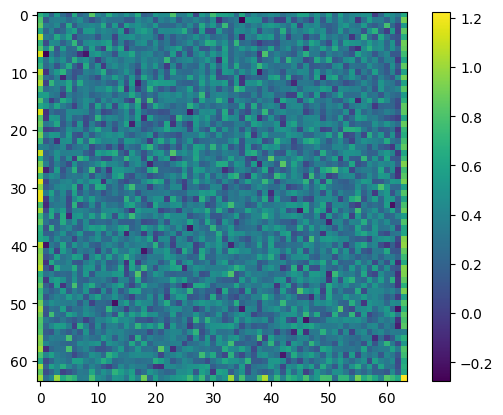

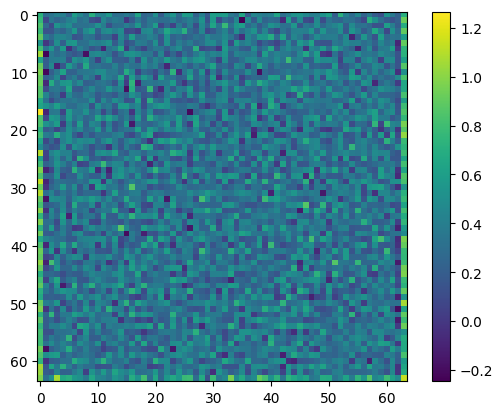

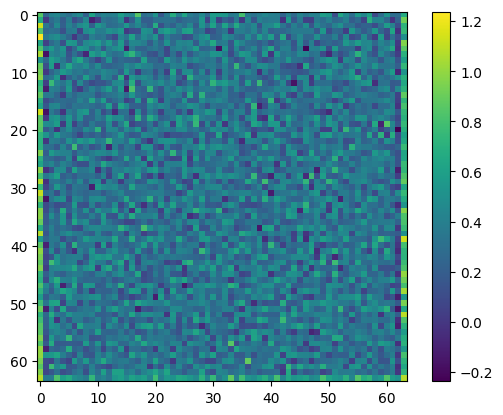

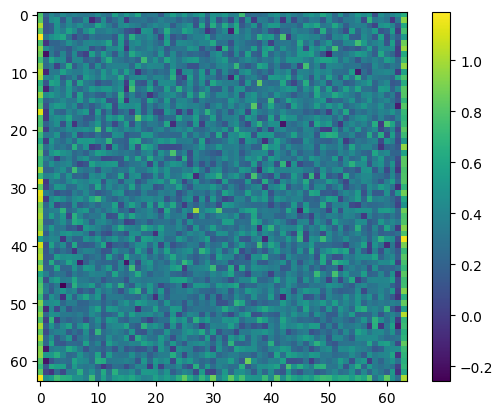

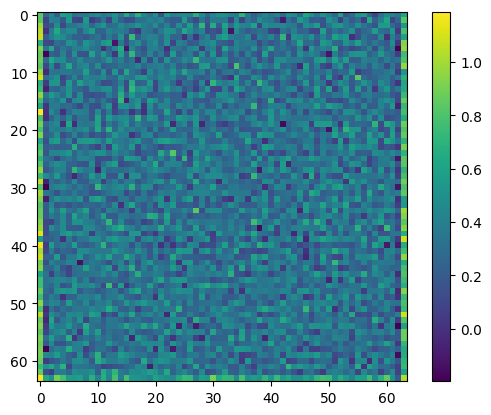

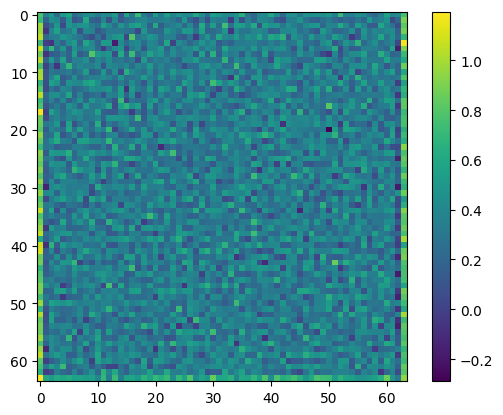

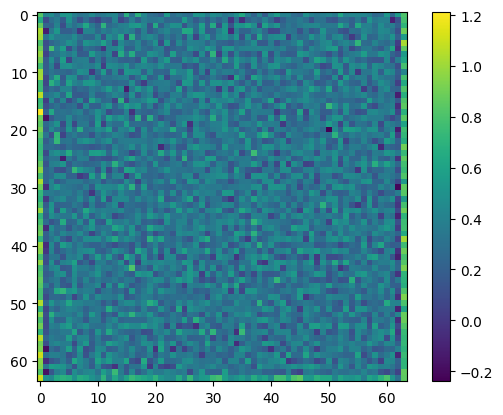

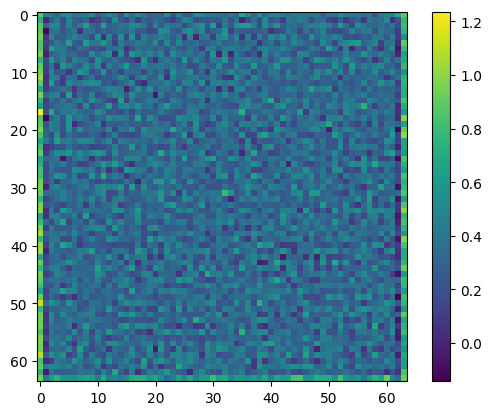

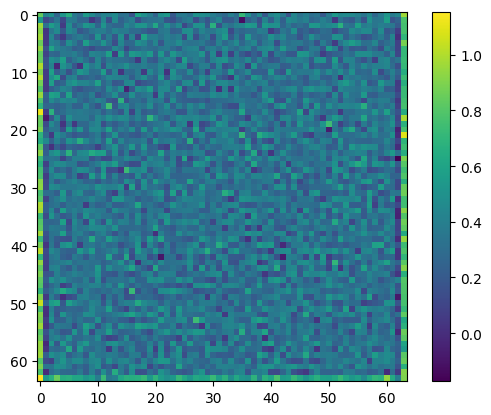

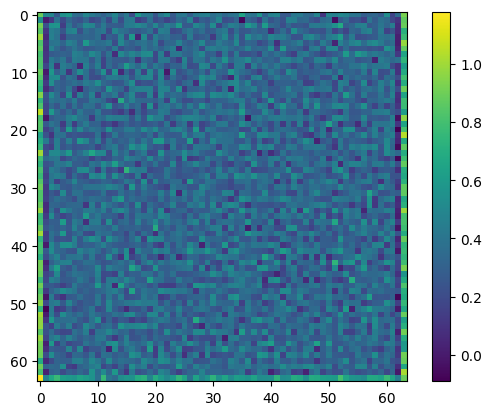

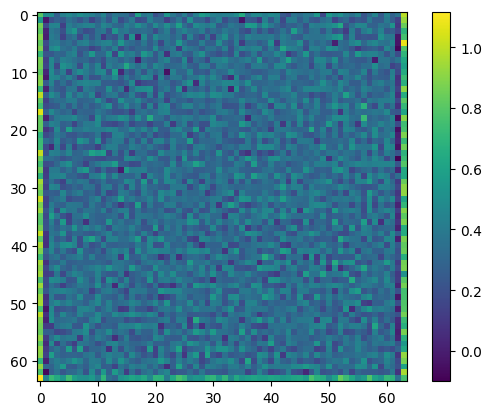

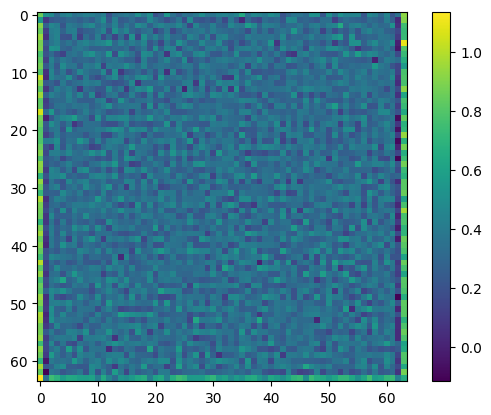

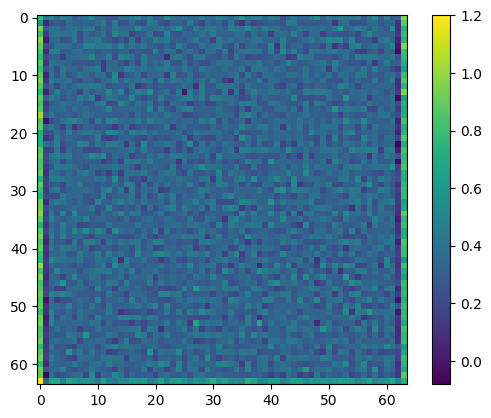

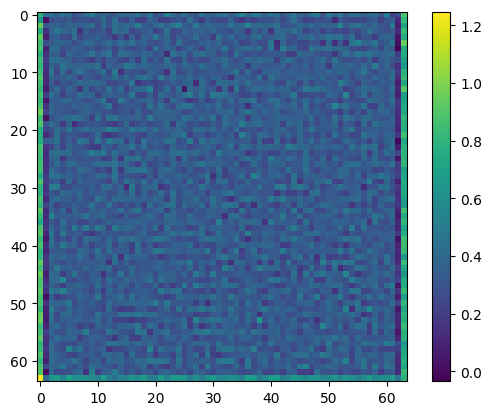

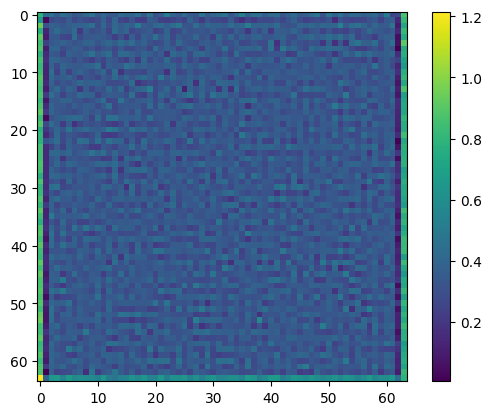

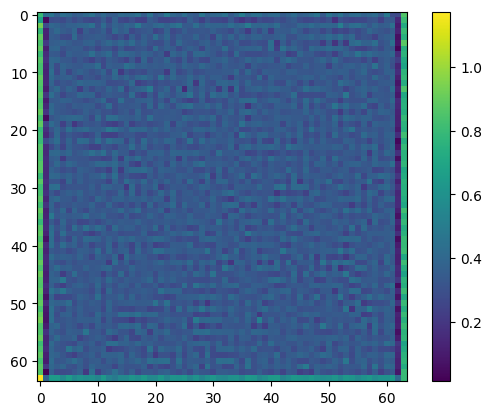

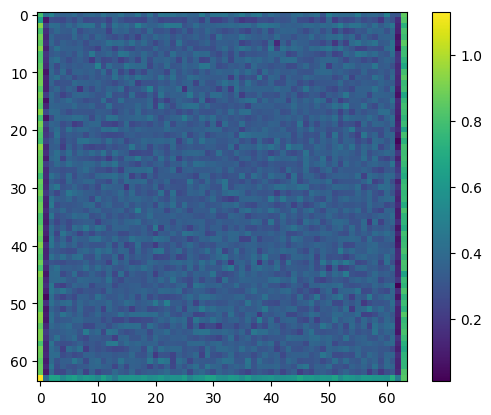

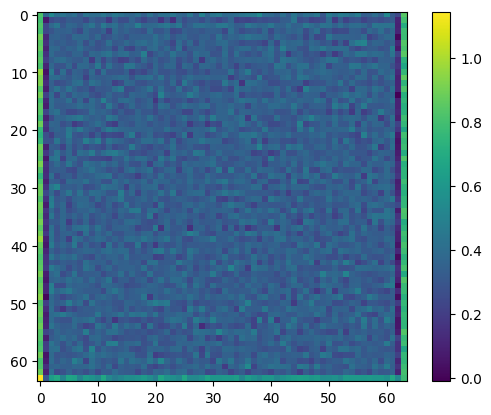

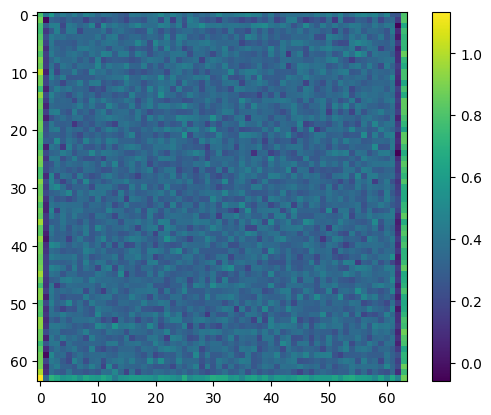

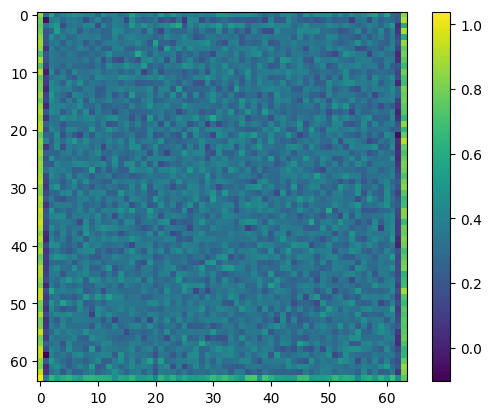

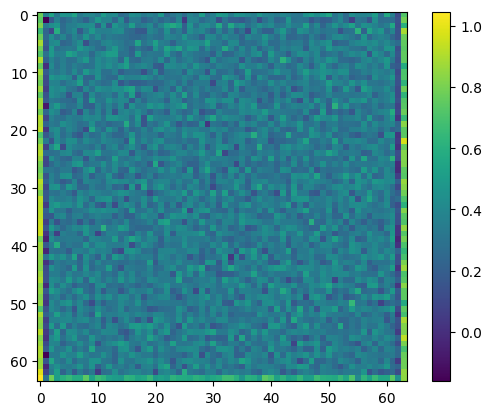

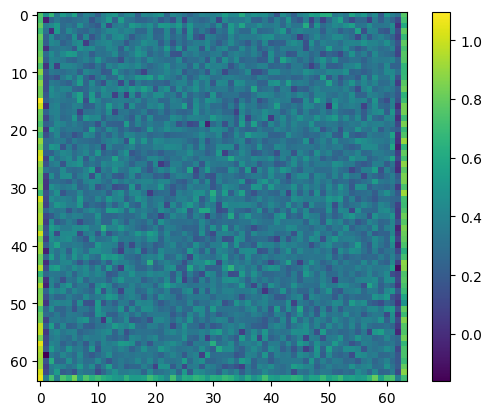

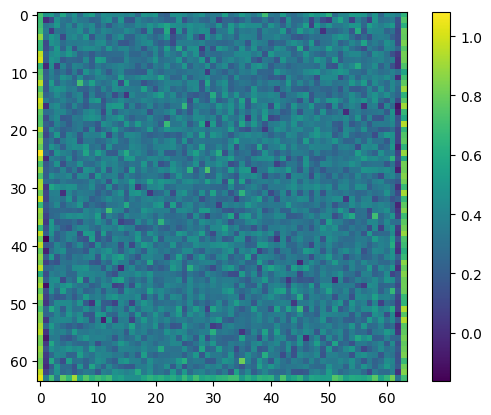

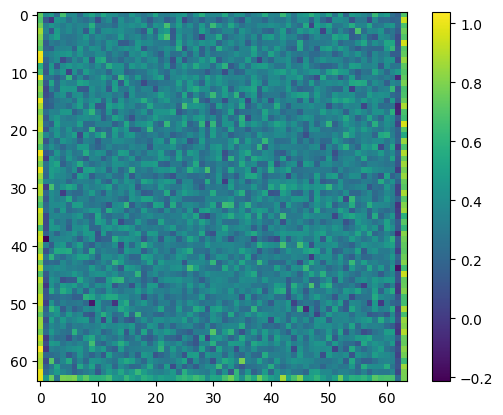

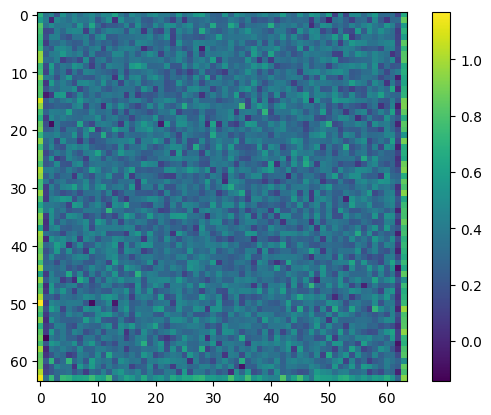

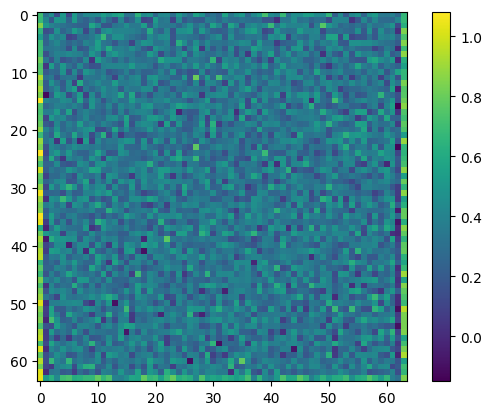

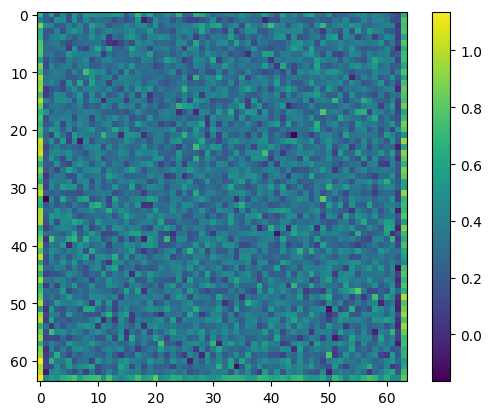

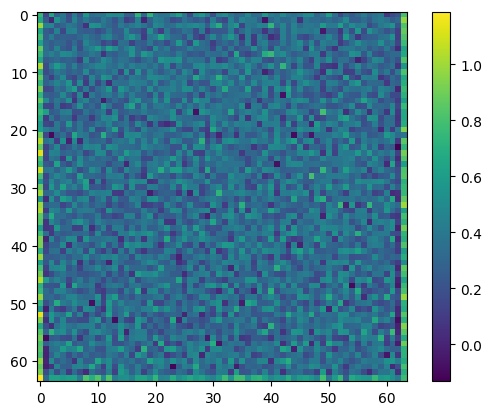

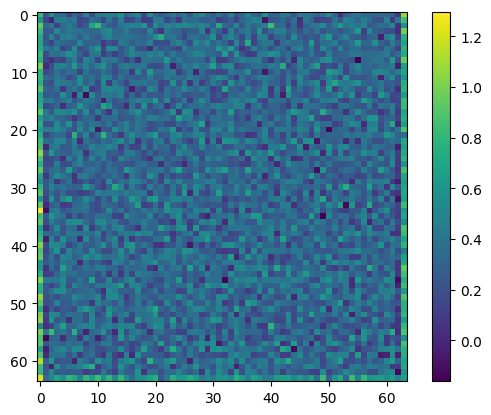

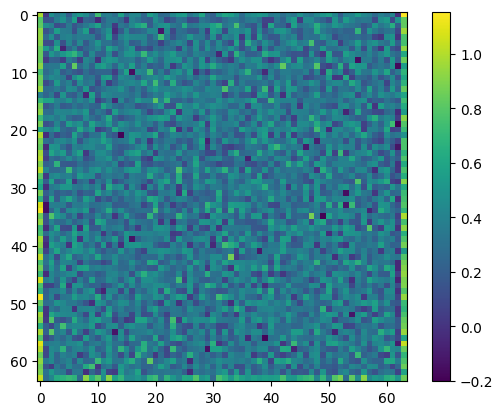

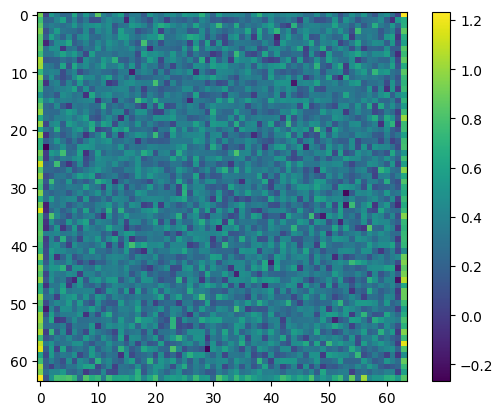

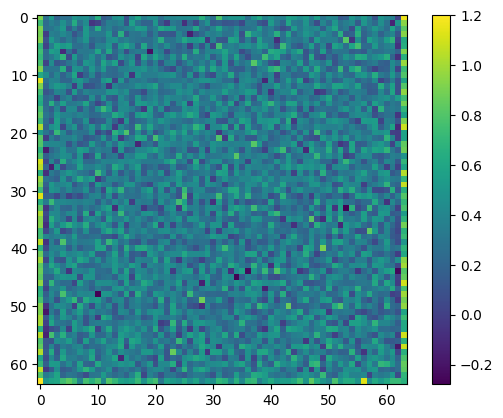

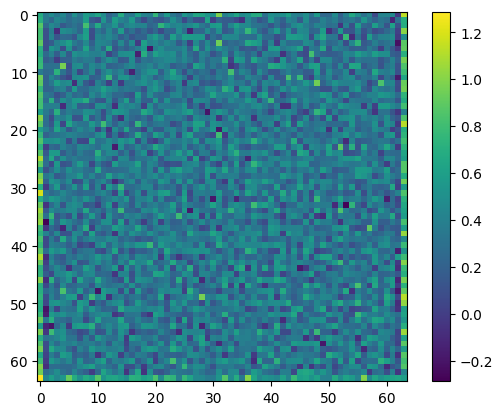

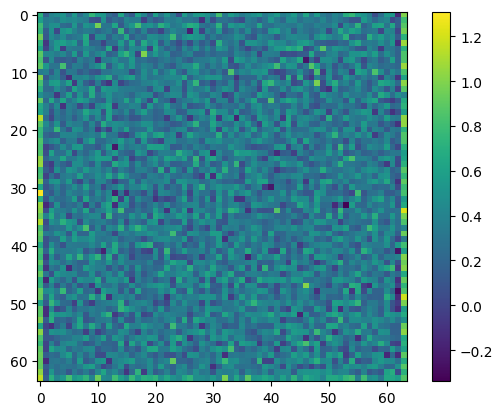

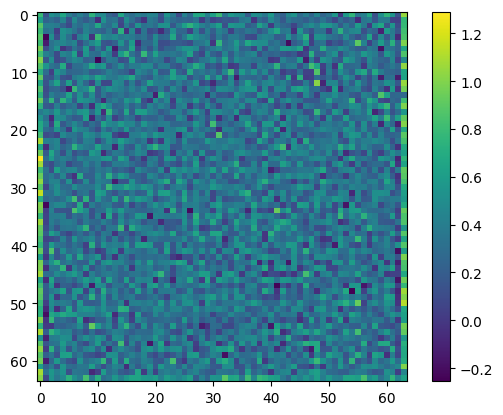

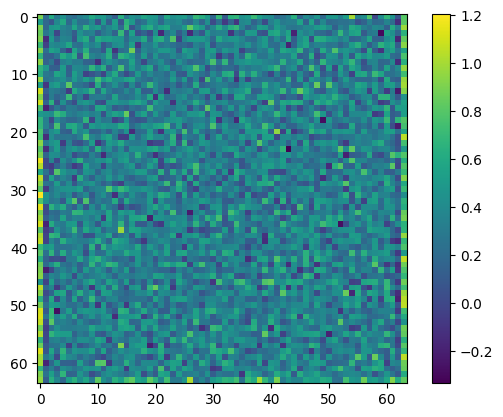

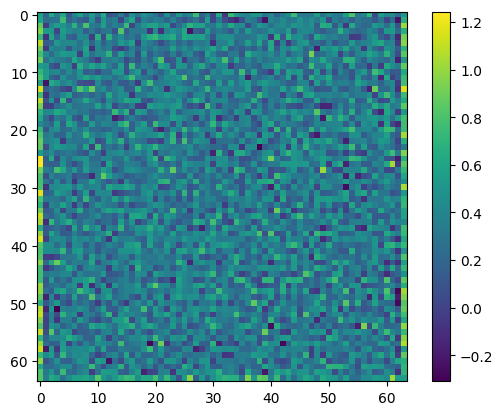

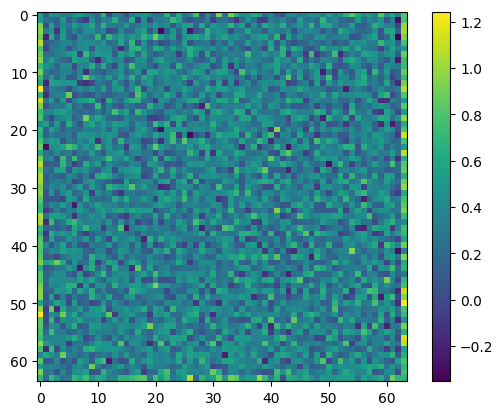

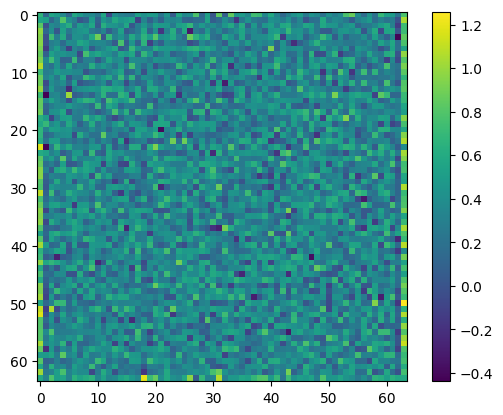

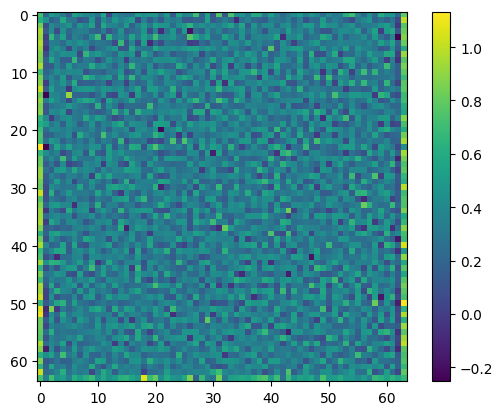

In [19]:
for i in range(50):
    plt.imshow(dsb.x_tot_plot[i, 0, 0,].cpu().detach().numpy())
    plt.colorbar()
    plt.show()

In [16]:
dsb.x_tot_plot[1, 0, 0,].cpu().detach().numpy()

array([[0.46977153, 0.32974988, 0.23457375, ..., 0.41960275, 0.47596234,
        0.494275  ],
       [0.89446175, 0.18679762, 0.4765969 , ..., 0.30484617, 0.55289614,
        0.55189043],
       [0.60285586, 0.540993  , 0.16182427, ..., 0.27466047, 0.15695235,
        0.58902466],
       ...,
       [0.5149191 , 0.2590345 , 0.15089874, ..., 0.2937616 , 0.3081258 ,
        0.5274269 ],
       [0.7411185 , 0.54838437, 0.39094648, ..., 0.29596552, 0.35262847,
        0.48966628],
       [0.93527806, 0.58466625, 0.8318821 , ..., 0.57954144, 0.5860486 ,
        0.75275666]], dtype=float32)

In [14]:
batch = next(dsb.save_init_dl)['T1']
fb = 'f'
batch = batch[0:1]

x_tot, out, steps_expanded = dsb.langevin.record_langevin_seq(
    dsb.net[fb],
    batch,
    ipf_it=1,
    sample=True
)

<class 'torch.cuda.OutOfMemoryError'>: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 

In [13]:
batch.shape

torch.Size([1, 1, 64, 64])

In [4]:
batch = next(dsb.save_init_dl)['T1']

In [5]:
batch

tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.000

In [6]:
from torchvision.utils import save_image

In [8]:
batch = (batch + 1) /2

In [9]:
batch

tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 5.9605e-08],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 2.9802e-08],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 2.9802e-08],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 2.9802e-08],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.9802e-08, 2.9802e-08, 2.9802e-08,  ..., 2.9802e-08,
           2.9802e-08, 2.9802e-08]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 5.9605e-08],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 2.9802e-08],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 2.9802e-08],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.00

In [10]:
save_image(batch, expe_dir / "test_tv_save_image.png")